In [60]:
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
import requests
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage
import pickle as pkl
from sklearn.neighbors import NearestNeighbors
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPool2D

In [61]:
YOLO_MODEL_PATH = "../../yolo_small"
FINETUNED_MODEL_PATH = "../../model"
IMAGE_PATH = "https://i.pinimg.com/736x/62/42/fb/6242fb3e35b6a6f434b577042e97dd24.jpg"
CAT_NAME = "shirt, blouse"

In [62]:
# This is the order of the categories list. NO NOT CHANGE. Just for visualization purposes
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

In [63]:
def idx_to_text(i):
    return cats[i]

In [64]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

# Random colors used for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        ax.text(xmin, ymin, idx_to_text(cl), fontsize=10,
                bbox=dict(facecolor=c, alpha=0.8))
    plt.axis('off')
    plt.show()
    plt.savefig("image.png")

def visualize_predictions(image, outputs, threshold=0.8):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # plot results
    plot_results(image, probas[keep], bboxes_scaled)


In [65]:
# Loading and Customizing the ResNet50 Model
sim_srch_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# Load the ResNet50 model with pretrained weights ('imagenet'), exclude the top classification layer, and set input size to (224, 224, 3)

sim_srch_model.trainable = False  # Freeze the model (disable training for the ResNet50 layers)

sim_srch_model = tf.keras.models.Sequential([sim_srch_model,  # Create a Sequential model and add the ResNet50 model
                                   GlobalMaxPool2D()  # Add a GlobalMaxPool2D layer to reduce feature dimensions
                                   ])

sim_srch_model.summary()  # Print the model summary

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [66]:
def extract_features_from_images(img_input, model):
    # Accept either a file path or a PIL image
    if isinstance(img_input, str):  # file path
        img = image.load_img(img_input, target_size=(224, 224))
    else:  # assume it's a PIL.Image.Image
        img = img_input.resize((224, 224))

    img_array = image.img_to_array(img)
    img_expand_dim = np.expand_dims(img_array, axis=0)
    img_preprocess = preprocess_input(img_expand_dim)

    result = model.predict(img_preprocess, verbose=0).flatten()
    norm_result = result / np.linalg.norm(result)

    return norm_result

In [67]:
feature_extractor = YolosFeatureExtractor.from_pretrained(YOLO_MODEL_PATH)
model = YolosForObjectDetection.from_pretrained(FINETUNED_MODEL_PATH)
# model.eval()  # Set model to eval mode

C:\Users\Sayan\AppData\Roaming\Python\Python312\site-packages\transformers\models\yolos\feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


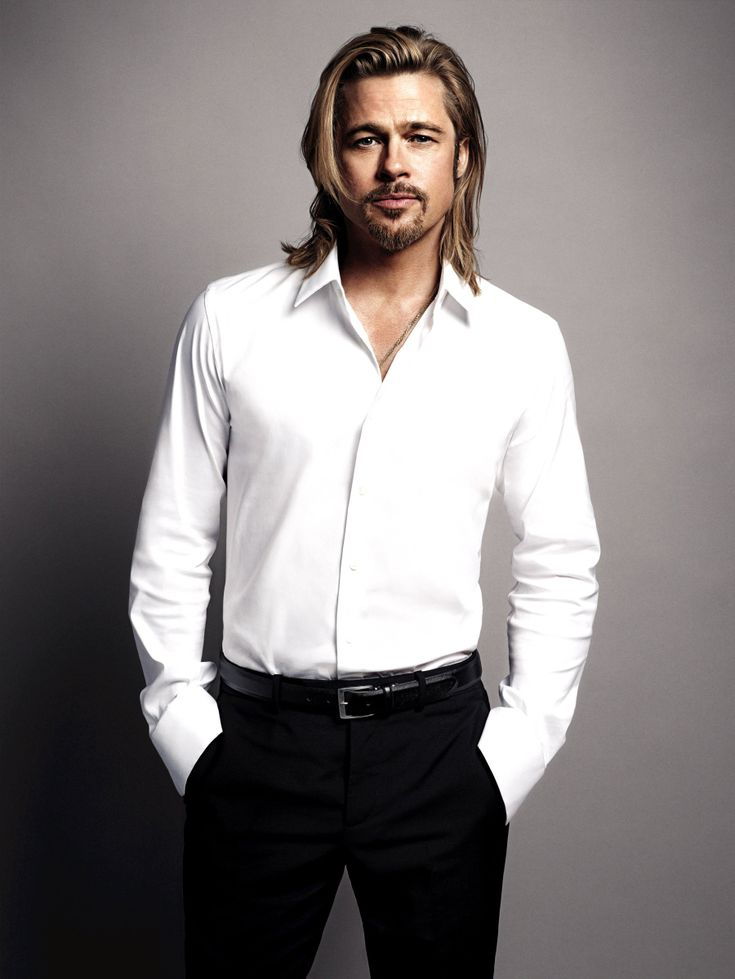

In [68]:
# Load image from file or URL
# image = Image.open("person_with_clothes.jpg").convert("RGB")
# Or:
image = Image.open(requests.get(IMAGE_PATH, stream=True).raw).convert("RGB")
image = fix_channels(ToTensor()(image))
# image = image.resize((600, 800))
image


In [69]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

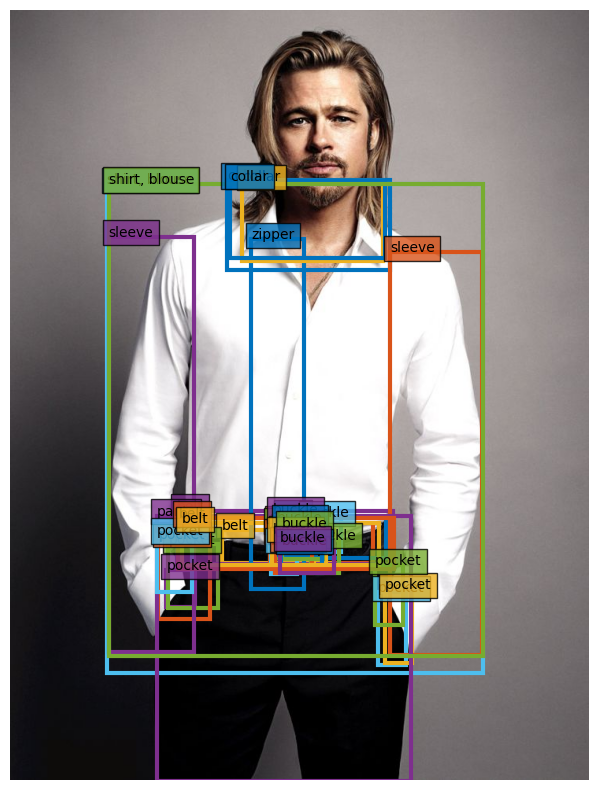

<Figure size 640x480 with 0 Axes>

In [70]:
img = visualize_predictions(image, outputs, threshold=0.3)

In [71]:
cropped_images = []
category_name = CAT_NAME

In [72]:
# Map label indices to names
probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.3
labels = probas[keep].argmax(-1)

# Rescale boxes to image coordinates
bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

# Extract and crop boxes matching the category
for label, box in zip(labels, bboxes_scaled):
    label_name = idx_to_text(label.item())
    if label_name == category_name:
        xmin, ymin, xmax, ymax = map(int, box.tolist())
        crop = image.crop((xmin, ymin, xmax, ymax))
        cropped_images.append(crop)

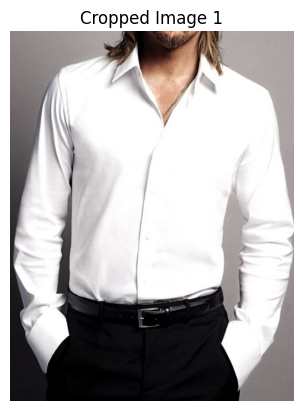

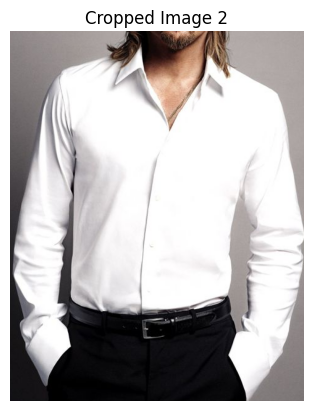

In [73]:
for idx, crop in enumerate(cropped_images):
    plt.figure()
    plt.imshow(crop)
    plt.title(f"Cropped Image {idx+1}")
    plt.axis("off")
    plt.show()

In [74]:
# Load saved features from the file
Image_features = pkl.load(open('Images_features.pkl', 'rb'))

# Load saved file names from the file
filenames = pkl.load(open('filenames.pkl', 'rb'))

# Check the shape of the feature vectors
np.array(Image_features).shape

(44441, 2048)

In [75]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
# Create a NearestNeighbors model with 6 neighbors, using brute-force search and Euclidean distance

neighbors.fit(Image_features)
# Fit the model using the extracted image features

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [76]:
from tensorflow.keras.preprocessing import image

for idx, crop in enumerate(cropped_images):
    # Extract features from the cropped image
    features = extract_features_from_images(crop, sim_srch_model)

    # Find the nearest neighbors
    distance, indices = neighbors.kneighbors([features])

    # Print results
    print(f"🔍 Nearest neighbors for Cropped Image {idx+1}:")
    print("Indices:", indices[0])
    print("Distances:", distance[0])
    print("------------")


🔍 Nearest neighbors for Cropped Image 1:
Indices: [44232 23173  1965 23155 19497 43390]
Distances: [0.75640196 0.77238154 0.777937   0.7800138  0.78078461 0.78119254]
------------
🔍 Nearest neighbors for Cropped Image 2:
Indices: [44232 23173  1965 24740 18936 23129]
Distances: [0.76457405 0.78139448 0.78515899 0.78611875 0.78768605 0.78968412]
------------


🧵 Top matches for Cropped Image 1:


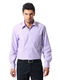

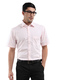

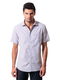

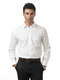

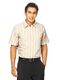

-------------
🧵 Top matches for Cropped Image 2:


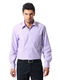

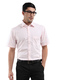

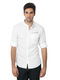

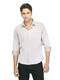

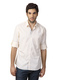

-------------


In [77]:
from IPython.display import Image

# Load the filenames list (paths to your stored catalog images)
with open("filenames.pkl", "rb") as f:
    filenames = pkl.load(f)

# Loop over each cropped image
for idx, crop in enumerate(cropped_images):
    features = extract_features_from_images(crop, sim_srch_model)
    distance, indices = neighbors.kneighbors([features])

    print(f"🧵 Top matches for Cropped Image {idx + 1}:")
    for i in range(1, 6):  # Top 5 (excluding the query itself, which is at index 0)
        try:
            display(Image(filename=filenames[indices[0][i]]))
        except Exception as e:
            print(f"❌ Error displaying image {i}: {e}")
    print("-------------")